前面的课程我们已经学习了如何使用python来编写简单的投资策略，但是我们也提到，在前面的投资策略中，我们忽略了许多实际的影响交易的因素，比如交易手续费以及除权除息对股票价格的影响等。本次课程我们将学习如何将手续费和除权等因素加入到我们的策略中来。为此我们将首先介绍一些相关的量化投资函数。

## 量化策略的设置函数


### 设置基准函数
设置基准函数的格式如下：
* set_benchmark(security)

其中security是指股票、指数或者ETF的代码。默认情况下，选定沪深300指数的每日价格。

### 设置佣金/印花税函数
设置佣金/印花税函数的语法格式如下：
* set_order_cost(cost, type, ref = None)

该函数用来设置每笔交易要收取的手续费，系统会根据用户指定的费率计算每笔交易的手续费。手续费主要包括券商手续费和印花税，中国A股市场目前为双边收费，券商手续费系默认值为万分之三，即0.03%，最少5元，印花税对卖方单边征收，对买方不再征收，系统默认为千分之一，即0.1%。

### 设置复权模式

除权除息就是指一家上市公司进行分红派息。当一家上市公司宣布年度分红派息方案并获得董事会和证监会的批准之后，即可确定股权登记日，而如果你在股权登记日（包含股权登记日那一天）后仍然持有该上市公司的股票的话，你就可以享受分红派息的权利。如果这家上市公司进行现金分红的话，那就是除息；如果是送红股或是配股的话，那就是除权；如果即现金分红有送股或配股的话，就是除权除息。

股票的分红有两种方式：分现金，或者分股票。因为分股票而向下调整股价就是除权。比如很常见的10送10、10转10，意思就是说，你持有10股，公司再送给10股，但是第二天股价也会变成原先的一半。除息呢，就是因为分给你现金了，而向下调整股价，这个就叫做除息。一般分给你多少钱，都会从股价里扣。所以第二天股价也会减少多数钱。比如某股票的分红方案为每10股派发现金红利67.87元。比如明天分红，今天持有100股，今天收盘价是400元一股，总金额是4万。那么明天分红后，10股分68元，那么100股可以能分680元。分红之后要除息的，分了多少股价是要减去多少的，每10股分68，股价就要减去6.8元，减完之总的资金并没有什么变化。

复权是指根据“除权前后流通股股东价值不变”原理，确定除权前后股价的等价换算关系。股票除权、除息之后，股价随之产生了变化，但实际成本并没有变化。这时对于股票价格，有以下三种操作：
- 不复权，即不进行前后复权操作。
- 向前复权（前复权），除权前每个交易日的交易价格换算成除权后的价格。就是保持现有价位不变，将以前的价格缩减，将除权前的K线向下平移，使图形吻合，保持股价走势的连续性。
- 向后复权（后复权），将除权后每个交易日的交易价格换算成除权前的价格。就是保持先前的价格不变，而将以后的价格增加。

以浦发银行前复权方式为例，2008年至2010年的分配方案为 

-  时间      送股   分红（每股） 
- 2010-6-10  0.3   0.15 
- 2009-6-9   0.4   0.23 
- 2008-4-24  0.3   0.16

选择以下几日的复权前的收盘价格 
- 2008-1-2    53.55 
- 2009-1-5    13.72 
- 2010-1-4    21.19 
- 2010-12-17  12.72 

对于2008-1-2(2008-1-2到2008-4-24之间的所有价格数据)的价格，需要做三次复权处理（2008年的权息调整，2009年的权息调整，2010年的权息调整） 
对于2009-1-5(2008-4-25到2009-6-9之间的所有价格数据)的价格，需要做二次复权处理（2009年的权息调整，2010年的权息调整） 
对于2010-1-4(2009-6-10到2010-6-10之间的所有价格数据)的价格，需要做一次复权处理（2010年的权息调整）

我们以2008-1-2日的复权计算为例
- 第一次调整，（53.55-0.15）/(1+0.3)=41.0769 
- 第二次调整，（41.0769-0.23）/(1+0.4)=29.1763 
- 第三次调整，（29.1763-0.16）/(1+0.3)=22.32 
第三次调整后的价格为最终复权价格。

前复权价格是由历史股票价格基于当前时间点进行前复权，历史每一天的股票数据包含了之后到当前的股票未来信息，当使用前复权参与回测时会使得回测本身包含未来价格函数，影响回测的效果。而后复权由于变动的是当前价格，会导致和实盘对接困难。目前主要使用的是动态复权（真实价格）模式。

设置动态复权（真实价格）调整模式的函数为
* set_option('use_real_price', True)

- 每天看到的当天的价格都是真实的(不复权的)

- 使用真实的价格下单, 交易详情和持仓详情里看到的都是真实价格

- 为了让编写代码简单, 通过数据获取函数API 拿到的都是基于当天日期的前复权价格. 比如: 回测运行到了2015-01-01这一天, history(3, '1d', 'close') 取得的就是在2015-01-01这一天所看到的前复权价格. 另一方面, 你在不同日期调用数据获取函数API返回的价格可能是不一样的, 因为我们在不同日期看到的前复权价格是不一样的. 比如在我们的例子中， 当回测进行到2008-4-23日，我们向前取三个交易日的价格，包括2008-04-22，2008-04-21，2008-04-20，当回测进行到2008-04-25时，向前取三个交易日包括2008-04-24，2008-04-23，2008-04-22因为已经经过了除权除息，两次取到的2008-04-22日的价格是不一样的。因为第二次取到的价格是经过前复权的。

- 每到新的一天, 如果持仓中有股票发生了拆合或者分红或者其他可能影响复权因子的情形, 平台会根据复权因子自动调整股票的数量, 如果调整后的数量是小数, 则向下取整到整数。 

# 量化策略的相关函数



## 量化策略的获取数据函数



### attribute_history()
attribute_history()用来查看某一只股票的历史数据，可以选这只股票的多个属性, 默认跳过停牌日期，不包括当天数据, 即使是在收盘后。其语法格式为：
* attribute_history(security, count, unit='1d',
                    fields=['open', 'close', 'high', 'low', 'volume', 'money'],
                    skip_paused=True, df=True，fq = 'pre')

其中参数为
- security: 股票代码
- count:    数量, 返回的结果集的行数
- unit:     单位时间长度, 几天或者几分钟, 现在支持 'Xd', 'Xm', X是一个正整数, 分别表示X天和X分钟(不论是按天还是按分钟回测都能拿到这两种单位的数据)。
- fields: 股票属性的list, 支持SecurityUnitData里面的所有基本属性，包含：['open', ' close', 'low', 'high', 'volume', 'money', 'factor', 'high_limit',' low_limit', 'avg', ' pre_close', 'paused']
- skip_paused: 是否跳过不交易日期(包括停牌, 未上市或者退市后的日期). 如果不跳过, 停牌时会使用停牌前的数据填充, 上市前或者退市后数据都为 nan, 默认是True
- df: 若是True, 数据返回的格式为DataFrame, 否则返回一个dict, 默认是True.
- fq: 前复权因子, 平台提供的价格都是前复权后的, 但是利用这个值可以算出原始价格, 方法是价格除以factor, 比如:
close/factor
- pre_close：前一个单位时间结束时的价格, 按天则是前一天的收盘价
- open：开盘价， 
- close：收盘价，
- low： 最低价，
- high： 最高价
- volume： 成交的股票数量，
- money：  成交的金额，
- avg  ： 一段时间的平均价。计算方法：股票是成交额处以成交量。
- factor：复权因子, 可以通过复权因子算出原始价格, 方法是价格除以factor, 比如: close/factor，
- high_limit：涨停价，
- low_limit：跌停价
- paused:逻辑数据 股票是否停牌,  停牌时open/close/low/high/pre_close依然有值,都等于停牌前的收盘价, volume=money=0

In [2]:
import pandas as pd

# 获取中国宝安（000009.XSHE）的历史数据信息
df1 = attribute_history('000009.XSHE',22,'1d',('open','close', 'high', 'low','money','avg', 'low_limit', 'factor'))
df1


,open,close,high,low,money,avg,low_limit,factor
2019-10-24,4.65,4.74,4.76,4.60,1.032927e+08,4.71,4.19,1.0
2019-10-25,4.76,4.80,4.80,4.71,1.082883e+08,4.76,4.27,1.0
2019-10-28,4.84,4.79,4.86,4.74,1.461834e+08,4.79,4.32,1.0
2019-10-29,4.80,4.66,4.80,4.66,9.186503e+07,4.72,4.31,1.0
2019-10-30,4.66,4.61,4.69,4.61,6.950919e+07,4.64,4.19,1.0
2019-10-31,4.61,4.56,4.64,4.54,6.084543e+07,4.58,4.15,1.0
2019-11-01,4.55,4.62,4.63,4.52,4.713796e+07,4.60,4.10,1.0
2019-11-04,4.62,4.62,4.67,4.61,5.583058e+07,4.64,4.16,1.0
2019-11-05,4.63,4.65,4.69,4.58,5.746621e+07,4.64,4.16,1.0
2019-11-06,4.63,4.68,4.74,4.63,9.117700e+07,4.70,4.19,1.0


In [9]:
# 显示开盘价，收盘价和成交金额的信息（根据列标签选取列）
df1[['open','close', 'money']]


,open,close,money
2019-09-26,4.53,4.44,7.453283e+07
2019-09-27,4.49,4.50,5.127282e+07
2019-09-30,4.51,4.41,5.392442e+07
2019-10-08,4.54,4.59,1.185836e+08
2019-10-09,4.55,4.62,7.270138e+07
2019-10-10,4.63,4.64,6.572037e+07
2019-10-11,4.64,4.65,6.357654e+07
2019-10-14,4.71,4.75,1.104638e+08
2019-10-15,4.76,4.76,9.705717e+07
2019-10-16,4.75,4.77,1.129766e+08


In [10]:
# 显示第2条到第5条观测（根据行的位置指标选取行）
df1[2:5]

,open,close,high,low,money,avg,low_limit,factor
2019-09-30,4.51,4.41,4.52,4.41,5.392442e+07,4.45,4.05,1.0
2019-10-08,4.54,4.59,4.66,4.50,1.185836e+08,4.59,3.97,1.0
2019-10-09,4.55,4.62,4.65,4.50,7.270138e+07,4.58,4.13,1.0


根据列标签选取数据，语法是
- df1.loc[行标签，列标签]

其中两个参数可以是列表也可以是单个字符，如果两个参数都是列表，则返回内容为DataFrame, 否则为Series.

In [11]:
# 根据行列标签选取数据
# 显示2019年10月28日数据
df1.loc["2019-10-28"]


open         4.840000e+00
close        4.790000e+00
high         4.860000e+00
low          4.740000e+00
money        1.461834e+08
avg          4.790000e+00
low_limit    4.320000e+00
factor       1.000000e+00
Name: 2019-10-28 00:00:00, dtype: float64

In [13]:
# 显示2019年10月28日的收盘价信息
df1.loc["2019-10-28", "close"]

4.79

In [15]:
# 显示从2019年10月28日到2019年11月1日的收盘价信息
df1.loc["2019-10-28":"2019-11-01", "close"]

2019-10-28    4.79
2019-10-29    4.66
2019-10-30    4.61
2019-10-31    4.56
2019-11-01    4.62
Name: close, dtype: float64

还可以使用位置选取数据，语法是
- df1.iloc[行位置，列位置]

In [19]:
# 选取第6行第3列的值
df1.iloc[6,3]

4.58

### get_price()函数

get_price()函数可以按照天或者分钟获取一支或多支股票的行情数据(attribute.history()只能处理一支股票的数据)

* get_price(security, count=None, start_date = None, end_date = None, frequency = 'daily', fields = None
                    fields=['open', 'close', 'high', 'low', 'volume', 'money'],
                    skip_paused=False, fq = 'pre')

- start_date: 开始时间
- end_date  : 结束时间


In [3]:
stock_set = ['000001.XSHE','000009.XSHE']
df2 = get_price(stock_set, start_date='2019-09-26', \
                end_date='2019-11-01', frequency='daily',panel = False)
df2

,time,code,open,close,high,low,volume,money
0,2019-09-26,000001.XSHE,15.86,15.71,16.04,15.66,168659258.0,2.673097e+09
1,2019-09-27,000001.XSHE,15.85,15.90,16.00,15.70,100770627.0,1.598567e+09
2,2019-09-30,000001.XSHE,15.75,15.59,15.89,15.57,104636317.0,1.645829e+09
3,2019-10-08,000001.XSHE,15.60,16.20,16.23,15.60,138667636.0,2.225025e+09
4,2019-10-09,000001.XSHE,16.10,16.25,16.52,16.02,131669341.0,2.145062e+09
5,2019-10-10,000001.XSHE,16.27,16.24,16.27,15.99,87974662.0,1.418752e+09
6,2019-10-11,000001.XSHE,16.20,16.81,16.95,16.20,140542282.0,2.335031e+09
7,2019-10-14,000001.XSHE,16.97,17.22,17.60,16.92,155763745.0,2.688930e+09
8,2019-10-15,000001.XSHE,17.25,17.18,17.35,16.82,88195542.0,1.503633e+09
9,2019-10-16,000001.XSHE,17.26,16.79,17.44,16.63,126767121.0,2.146151e+09


如果我们只需要"000001.XHSE"的数据，则我们需要对df2数据框使用逻辑条件提取

In [4]:
df2_1 = df2[df2.code == '000001.XSHE']
df2_1

,time,code,open,close,high,low,volume,money
0,2019-09-26,000001.XSHE,15.86,15.71,16.04,15.66,168659258.0,2.673097e+09
1,2019-09-27,000001.XSHE,15.85,15.90,16.00,15.70,100770627.0,1.598567e+09
2,2019-09-30,000001.XSHE,15.75,15.59,15.89,15.57,104636317.0,1.645829e+09
3,2019-10-08,000001.XSHE,15.60,16.20,16.23,15.60,138667636.0,2.225025e+09
4,2019-10-09,000001.XSHE,16.10,16.25,16.52,16.02,131669341.0,2.145062e+09
5,2019-10-10,000001.XSHE,16.27,16.24,16.27,15.99,87974662.0,1.418752e+09
6,2019-10-11,000001.XSHE,16.20,16.81,16.95,16.20,140542282.0,2.335031e+09
7,2019-10-14,000001.XSHE,16.97,17.22,17.60,16.92,155763745.0,2.688930e+09
8,2019-10-15,000001.XSHE,17.25,17.18,17.35,16.82,88195542.0,1.503633e+09
9,2019-10-16,000001.XSHE,17.26,16.79,17.44,16.63,126767121.0,2.146151e+09


In [5]:
df2_9 = df2[df2.code == '000009.XSHE']
df2_9

,time,code,open,close,high,low,volume,money
22,2019-09-26,000009.XSHE,4.53,4.44,4.57,4.40,16673356.0,7.453283e+07
23,2019-09-27,000009.XSHE,4.49,4.50,4.54,4.46,11379603.0,5.127282e+07
24,2019-09-30,000009.XSHE,4.51,4.41,4.52,4.41,12118074.0,5.392442e+07
25,2019-10-08,000009.XSHE,4.54,4.59,4.66,4.50,25860422.0,1.185836e+08
26,2019-10-09,000009.XSHE,4.55,4.62,4.65,4.50,15859767.0,7.270138e+07
27,2019-10-10,000009.XSHE,4.63,4.64,4.66,4.60,14208553.0,6.572037e+07
28,2019-10-11,000009.XSHE,4.64,4.65,4.68,4.58,13727221.0,6.357654e+07
29,2019-10-14,000009.XSHE,4.71,4.75,4.78,4.69,23291975.0,1.104638e+08
30,2019-10-15,000009.XSHE,4.76,4.76,4.80,4.71,20404535.0,9.705717e+07
31,2019-10-16,000009.XSHE,4.75,4.77,4.85,4.75,23521645.0,1.129766e+08


## 量化策略的交易函数

### order()：下单函数

order()为下单函数，语法为


参数含义为：
- security: 标的代码
- amount:   交易数量, 正数表示买入, 负数表示卖出
- style: 下单类型，市价单还是限价单，默认是市价单
- side: 'long'/'short'，操作多单还是空单。默认为多单，股票、基金暂不支持开空单。
- pindex: 在使用set_subportfolios创建了多个仓位时，指定subportfolio 的序号, 从 0 开始, 比如 0 指定第一个 subportfolio, 1 指定第二个 subportfolio，默认为0。

### order_target():目标股数下单

通过买卖，将股票仓位调整至一定数量（单位：股），其中security是股票名称，amount是股票数量
* order_target(security, amount, style=None, side='long', pindex=0, close_today=False)


### order_value():价值下单函数

order_value(security,value)，含义是买卖一定价值量（单位：元）股票，security是股票代码，value是价值量。value为负数时就是代表卖出了。

### order_target_value():目标股数下单

通过买卖，将股票仓位调整至一定数量（单位：元），其中security是股票名称，amount是股票数量
* order_target_value(security, amount)

In [ ]:
# 买入10000元的平安银行，如果当前股票市价是10元，则代表买入1000股，如果除不开系统会自动调整成相近的合理数量。卖出时也会。
  order_value("000001.XSHE",10000)
# 卖出10000元的平安银行，如果当前股票市价是100元，则代表卖出100股
  order_value("000001.XSHE",-10000)

## 实例分析

接下来我们利用聚宽回测平台回测我们提过的单均线策略，该策略用于单只股票的择时。

In [ ]:
# 导入函数库
from jqdata import *

# 初始化函数，设定基准等等
def initialize(context):
    # 设定沪深300作为基准
    set_benchmark('000300.XSHG')
    # 开启动态复权模式(真实价格)
    set_option('use_real_price', True)
    # 输出内容到日志 log.info()
    log.info('初始函数开始运行且全局只运行一次')
    
    ### 股票相关设定 ###
    # 股票类每笔交易时的手续费是：买入时佣金万分之三，卖出时佣金万分之三加千分之一印花税, 每笔交易佣金最低扣5块钱
    set_order_cost(OrderCost(close_tax=0.001, open_commission=0.0003, close_commission=0.0003, min_commission=5), type='stock')
    
    ## 运行函数（reference_security为运行时间的参考标的；传入的标的只做种类区分，因此传入'000300.XSHG'或'510300.XSHG'是一样的）
      # 开盘前运行
    run_daily(before_market_open, time='before_open', reference_security='000300.XSHG') 
      # 开盘时运行
    run_daily(market_open, time='open', reference_security='000300.XSHG')
      # 收盘后运行
    run_daily(after_market_close, time='after_close', reference_security='000300.XSHG')
    
## 开盘前运行函数     
def before_market_open(context):
    # 输出运行时间
    log.info('函数运行时间(before_market_open)：'+str(context.current_dt.time()))

    # 给微信发送消息（添加模拟交易，并绑定微信生效）
    send_message('美好的一天~')

    # 要操作的股票：平安银行（g.为全局变量）
    g.security = '000001.XSHE'
    
## 开盘时运行函数
def market_open(context):
    log.info('函数运行时间(market_open):'+str(context.current_dt.time()))
    security = g.security
    # 获取股票的收盘价
    close_data = attribute_history(security, 5, '1d', ['close'])
    # 取得过去五天的平均价格
    MA5 = close_data['close'].mean()
    # 取得上一时间点价格
    current_price = close_data['close'][-1]
    # 取得当前的现金
    cash = context.portfolio.available_cash

    # 如果上一时间点价格高出五天平均价1%, 则全仓买入
    if current_price > 1.01*MA5:
        # 记录这次买入
        log.info("价格高于均价 1%%, 买入 %s" % (security))
        # 用所有 cash 买入股票
        order_value(security, cash)
    # 如果上一时间点价格低于五天平均价, 则空仓卖出
    elif current_price < MA5 and context.portfolio.positions[security].closeable_amount > 0:
        # 记录这次卖出
        log.info("价格低于均价, 卖出 %s" % (security))
        # 卖出所有股票,使这只股票的最终持有量为0
        order_target(security, 0)
 
## 收盘后运行函数  
def after_market_close(context):
    log.info(str('函数运行时间(after_market_close):'+str(context.current_dt.time())))
    #得到当天所有成交记录
    trades = get_trades()
    for _trade in trades.values():
        log.info('成交记录：'+str(_trade))
    log.info('一天结束')
    log.info('##############################################################')


在聚宽中，股票量化交易策略首先是要导入聚宽数据库，命令是：
- import jqdata

其次是编写四个python函数，分别是初始化函数（initialize）、开盘前运行函数（before_market_open）、看盘时运行函数（markrt_open）, 收盘后运行函数(after_market_close)。

## initialize（）


initialize（）是初始化方法，在整个回测、模拟实盘中最开始执行一次，用于初始一些全局变量，格式如下

In [1]:
def initialize(context):
    # g为全局变量
    g.security = "000001.XSHE"

In [2]:
run_daily/run_weekly/run_monthly 是定时运行策略

SyntaxError: invalid syntax (<ipython-input-2-d0f583c55e83>, line 1)

In [ ]:
def initialize(context):
    ## func是自己定义的函数
    # 按月运行
    run_monthly(func, monthday, time='9:30', reference_security, force=False)
    # 按周运行
    run_weekly(func, weekday, time='9:30', reference_security, force=False)
    # 每天内何时运行(没有force属性)
    run_daily(func, time='9:30', reference_security)

# 研究模块调用回测功能

首先打开策略编译页面，找到algorithmId, 我们以我们刚才提到的单均线策略为例子

In [1]:
# 记得此处传入你自己的 algorithmId
out_algorithm_id = create_backtest('ef687a6ed07f4f5c0ab6a05ffcaf0484',\
                                   '2016-06-01', '2016-12-31', \
                                    frequency="day",initial_cash=100000, \
                                   #initial_positions=InitialPositions, \
                                   #extras=extra_vars、
                                  )
out_algorithm_id

'6ff9da76bfc36743809563c9a2e6493b'

In [2]:
gt = get_backtest(out_algorithm_id)

In [3]:
gt.get_status()        # 获取回测状态

'done'

In [4]:
gt.get_params()        # 获取回测参数

{'algorithm_id': 'ef687a6ed07f4f5c0ab6a05ffcaf0484',
 'end_date': '2016-12-31 23:59:59',
 'extras': {},
 'frequency': 'day',
 'initial_cash': '100000',
 'initial_positions': [],
 'name': '这是一个简单的策略-32',
 'package_version': '1.0',
 'python_version': '2',
 'start_date': '2016-06-01 00:00:00'}

In [5]:
gt.get_results()       # 获取收益曲线

[{'benchmark_returns': -0.0028426658589835174,
  'returns': -0.004099820000000087,
  'time': '2016-06-01 16:00:00'},
 {'benchmark_returns': -0.0007761329648279247,
  'returns': -0.005999819999999878,
  'time': '2016-06-02 16:00:00'},
 {'benchmark_returns': 0.006237458827092812,
  'returns': -0.0021998199999999635,
  'time': '2016-06-03 16:00:00'},
 {'benchmark_returns': 0.0029120761241308024,
  'returns': -0.001249819999999957,
  'time': '2016-06-06 16:00:00'},
 {'benchmark_returns': 0.0023631040270575276,
  'returns': -0.00029981999999983966,
  'time': '2016-06-07 16:00:00'},
 {'benchmark_returns': -0.0017573417130454239,
  'returns': -0.0021998199999998524,
  'time': '2016-06-08 16:00:00'},
 {'benchmark_returns': -0.032566034402251365,
  'returns': -0.01834981999999985,
  'time': '2016-06-13 16:00:00'},
 {'benchmark_returns': -0.029524602783982612,
  'returns': -0.01962557499999995,
  'time': '2016-06-14 16:00:00'},
 {'benchmark_returns': -0.0167815091053648,
  'returns': -0.01962557

In [8]:
import pandas as pd
data_returns = gt.get_results()
returns = pd.DataFrame.from_dict(data_returns)

In [9]:
returns.head()

,benchmark_returns,returns,time
0,-0.002843,-0.00410,2016-06-01 16:00:00
1,-0.000776,-0.00600,2016-06-02 16:00:00
2,0.006237,-0.00220,2016-06-03 16:00:00
3,0.002912,-0.00125,2016-06-06 16:00:00
4,0.002363,-0.00030,2016-06-07 16:00:00


In [10]:
returns.tail()

,benchmark_returns,returns,time
139,0.048221,-0.056092,2016-12-26 16:00:00
140,0.046325,-0.056092,2016-12-27 16:00:00
141,0.041750,-0.056092,2016-12-28 16:00:00
142,0.040447,-0.056092,2016-12-29 16:00:00
143,0.044334,-0.056092,2016-12-30 16:00:00


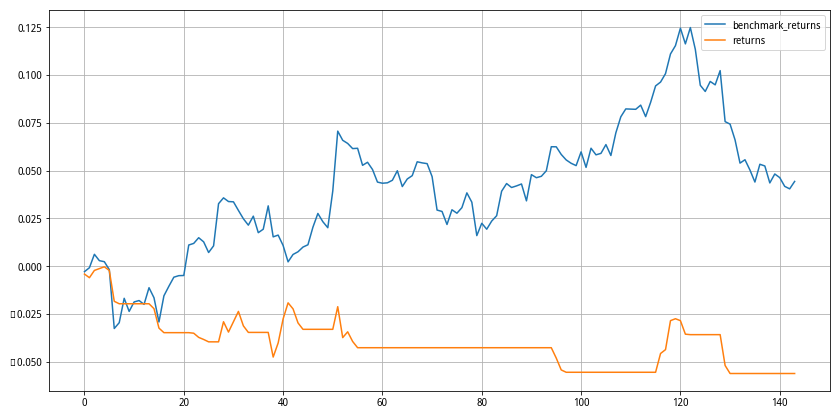

In [24]:
returns[['benchmark_returns','returns']].plot(grid = True, figsize = (14,7))

In [12]:
gt.get_risk()          # 获取总的风险指标

{'__version': 101,
 'algorithm_return': -0.05609199000000009,
 'algorithm_volatility': 0.06643936428422649,
 'alpha': -0.1434604891244914,
 'annual_algo_return': -0.09536138026615548,
 'annual_bm_return': 0.07822025852607628,
 'avg_excess_return': -0.0006754125644689857,
 'avg_position_days': 36.0,
 'avg_trade_return': -0.004745778894163128,
 'benchmark_return': 0.04433422935675546,
 'benchmark_volatility': 0.12464059924220786,
 'beta': 0.21190617674158863,
 'day_win_ratio': 0.4513888888888889,
 'excess_return': -0.09616291081315287,
 'excess_return_max_drawdown': 0.15515516530464546,
 'excess_return_max_drawdown_period': ['2016-06-13', '2016-12-01'],
 'excess_return_sharpe': -1.741395528553133,
 'information': -1.501455268883916,
 'lose_count': 6,
 'max_drawdown': 0.0560919900000002,
 'max_drawdown_period': ['2016-06-01', '2016-12-13'],
 'max_leverage': 0.0,
 'period_label': '2016-12',
 'profit_loss_ratio': 0.42188782489740084,
 'sharpe': -2.037367180201812,
 'sortino': -1.77389463042

In [13]:
gt.get_period_risks()  # 获取分月计算的风险指标

{'algorithm_return':          one_month  three_month  six_month  twelve_month
 2016-06  -0.034737          NaN        NaN           NaN
 2016-07   0.007455          NaN        NaN           NaN
 2016-08  -0.015491    -0.042606        NaN           NaN
 2016-09   0.000000    -0.008152        NaN           NaN
 2016-10  -0.013413    -0.028696        NaN           NaN
 2016-11   0.021086     0.007390  -0.035531           NaN
 2016-12  -0.021318    -0.014086  -0.022123           NaN,
 'benchmark_return':          one_month  three_month  six_month  twelve_month
 2016-06  -0.004934          NaN        NaN           NaN
 2016-07   0.015856          NaN        NaN           NaN
 2016-08   0.038659     0.049922        NaN           NaN
 2016-09  -0.022390     0.031504        NaN           NaN
 2016-10   0.025513     0.041309        NaN           NaN
 2016-11   0.060463     0.063168   0.116243           NaN
 2016-12  -0.064421     0.017459   0.049513           NaN,
 'alpha':          one_month  

In [14]:
gt.get_period_risks()['alpha'] # 获取分月计算的风险指标中的alpha

,one_month,three_month,six_month,twelve_month
2016-06,-0.362132,NaN,NaN,NaN
2016-07,0.027225,NaN,NaN,NaN
2016-08,-0.303319,-0.239783,NaN,NaN
2016-09,-0.040000,-0.083798,NaN,NaN
2016-10,-0.269239,-0.173827,NaN,NaN
2016-11,0.005371,-0.034660,-0.155319,NaN
2016-12,-0.114697,-0.105062,-0.094934,NaN


In [ ]:
import time
import datetime

'''
================================================================================
总体回测前
================================================================================
'''

#总体回测前要做的事情
def initialize(context):
    set_params()        #1设置策参数
    set_variables()     #2设置中间变量
    set_backtest()      #3设置回测条件
      


#1
#设置策略参数
def set_params():
    g.N = 30   # 设置移动均线天数
    g.tc = 30  # 设置调仓天数
    g.num_stocks = 10  # 设置每次调仓选取的股票数量

#2
#设置中间变量
def set_variables():
    g.t = 0 #记录回测运行的天数
    g.if_trade = False #当天是否交易

#3
#设置回测条件
def set_backtest():
    set_benchmark('000300.XSHG')
    set_option('use_real_price',True) # 用真实价格交易
    log.set_level('order','error')    # 设置报错等级




'''
================================================================================
每天开盘前
================================================================================
'''

#每天开盘前要做的事情
def before_trading_start(context):
    if g.t%g.tc==0:
        #每g.tc天，交易一次行
        g.if_trade=True 
        # 设置手续费与手续费
        set_slip_fee(context) 
        # 设置可行股票池：获得当前开盘的沪深300股票池并剔除当前或者计算样本期间停牌的股票
        g.feasible_stocks = set_feasible_stocks(get_index_stocks('000300.XSHG'),g.N,context)
    g.t+=1

#4
# 设置可行股票池：
# 过滤掉当日停牌的股票,且筛选出前days天未停牌股票
# 输入：stock_list为list类型,样本天数days为int类型，context（见API）
# 输出：list
def set_feasible_stocks(stock_list,days,context):
    # 得到是否停牌信息的dataframe，停牌的1，未停牌得0
    suspened_info_df = get_price(list(stock_list), start_date=context.current_dt, end_date=context.current_dt, frequency='daily', fields='paused')['paused'].T
    # 过滤停牌股票 返回dataframe
    unsuspened_index = suspened_info_df.iloc[:,0]<1
    # 得到当日未停牌股票的代码list:
    unsuspened_stocks = suspened_info_df[unsuspened_index].index
    # 进一步，筛选出前days天未曾停牌的股票list:
    feasible_stocks=[]
    current_data=get_current_data()
    for stock in unsuspened_stocks:
        if sum(attribute_history(stock, days, unit='1d',fields=('paused'),skip_paused=False))[0]==0:
            feasible_stocks.append(stock)
    return feasible_stocks
    
#5
# 根据不同的时间段设置滑点与手续费
def set_slip_fee(context):
    # 将滑点设置为0
    set_slippage(FixedSlippage(0)) 
    # 根据不同的时间段设置手续费
    dt=context.current_dt
    log.info(type(context.current_dt))
    
    if dt>datetime.datetime(2013,1, 1):
        set_commission(PerTrade(buy_cost=0.0003, sell_cost=0.0013, min_cost=5)) 
        
    elif dt>datetime.datetime(2011,1, 1):
        set_commission(PerTrade(buy_cost=0.001, sell_cost=0.002, min_cost=5))
            
    elif dt>datetime.datetime(2009,1, 1):
        set_commission(PerTrade(buy_cost=0.002, sell_cost=0.003, min_cost=5))
                
    else:
        set_commission(PerTrade(buy_cost=0.003, sell_cost=0.004, min_cost=5))
        
        
        
        
'''
================================================================================
每天交易时
================================================================================
'''

def handle_data(context,data):
    if g.if_trade == True:
        # 依本策略的买入信号，得到应该买的股票列表
        MR_should_buy = buy_signal(context, data)
        
        # 查看持仓情况
        if len(context.portfolio.positions)>0:
            holding = context.portfolio.positions
        else:
            holding = []

        # 计算每支股票分到多少钱
        cash_per_stock = context.portfolio.portfolio_value / g.num_stocks
        # 对于不需要持仓的股票，全仓卖出
        for stock in holding:
            if stock not in MR_should_buy:
                order_target_value(stock,0)
        # 对于需要持仓的股票，按分配到的份额买入
        log.info(MR_should_buy)
        for stock in MR_should_buy:
            order_target_value(stock,cash_per_stock)
            
    g.if_trade = False



#6
# 依本策略的买入信号，得到应该买的股票列表
# 输入：context, data（见API），输出：应该买的股票列表，list类型
def buy_signal(context, data):
    # 获差率列表
    difference_ratio_table = compute_difference_ratio(context, data, g.feasible_stocks) 
    # 按差率从大到小排列
    sorted_table = difference_ratio_table.sort(columns = 'difference_ratio', ascending = False)
    # 返回排列好的股票list（将sorted_table第一列转换成列表）
    sorted_list = sorted_table.iloc[:,1].tolist()
    # 截取最高的g.num_stocks个
    should_buy = sorted_list[0:g.num_stocks]
    return should_buy



#7
# 计算差率列表
# 输入：context, data（见API）,stocks为list类型
# 输出：DataFrame: 列 stock 为股票名，列 difference_ratio 为差率
def compute_difference_ratio(context, data, stocks):
    # 创建差率字典
    difference_ratio_table = []
    for stock in stocks:
        # 获取数据
        h = attribute_history(stock, g.N, '1d', ['close'])
        # 均线
        ma = sum(h['close']) / g.N
        # 获取现价
        current_price = data[stock].price
        # 计算差率
        difference_ratio = (ma - current_price) / ma 
        difference_ratio_table.append({'stock': stock, 'difference_ratio' : difference_ratio})
    return(pd.DataFrame(difference_ratio_table))




'''
================================================================================
每天收盘后
================================================================================
'''

# 每日收盘后要做的事情（本策略中不需要）
def after_trading_end(context):
    return



## 风险测度

关于策略的风险测度评价，我们主要讲解三种：夏普比率(Sharpe Ratio), 信息比率(Information Ratio)和最大回撤（Max Drawdown）。

### 夏普比率（Sharpe Ratio）

Sharpe Ratio表示每承受一单位风险，会产生多少超额收益，公式如下：

$$SR = \frac{E[R_{p}]-R_{f}}{\sigma_{I}}$$

这里各参数的意义如下：

- $E[R_{p}]$为策略的期望收益率
- $E[R_{f}]$为无风险收益率
- $\sigma_{s} = std(E[R_{p}])$

### 信息比率（ Information ）

Information Ratio是用来衡量单位超额风险带来的超额收益。计算公式如下：

$$IR = \frac{E[R_{p}]-E[R_{b}]}{\sigma_{I}}$$

这里各参数的意义如下：

- $E[R_{p}]$为策略的期望收益率
- $E[R_{b}]$为基准期望收益率
- $\sigma_{I} = std(R_{p}-R_{b})$

### 索提诺比率（ Sornito ）

索提诺比率表示每一单位的下行风险将获得多少超额回报：

$$IR = \frac{E[R_{p}]-E[R_{f}]}{\sigma_{pd}}$$

这里各参数的意义如下：

- $E[R_{p}]$为策略的期望收益率
- $E[R_{f}]$为无风险收益率
- $\sigma_{pd}$为策略下行波动率

### 最大回撤

#### 回撤（Drawdown）

从数学意义上看，如果某资产组合在时刻$\tau$的回撤是指资产$(0,\tau)$的最高峰值与现在价值$P_{\tau}$之间的回落值，用数学公式可以表达为：

$$D(\tau)=max[0,max_{t\in(0,\tau)}(P_{t}-P_{\tau})]$$

对应的回撤比率为：

$$d(\tau) = \frac{D(\tau)}{max_{t\in(0,\tau)}P_{t}}$$.


#### 最大回撤

最大回撤率，也可以理解成最大亏损率，是一个相对的概念，在选定周期内任一历史时点往后推，产品净值走到最低点时的收益率回撤幅度的最大值，用来描述买入产品后可能出现的最糟糕情况，可以理解为在这区间任意时点买卖所可能的最大亏损率。

在$T$时刻的最大回撤MDD(T)就是资产在时间段$(0,T)$内的回撤的最大值，

$$MDD(T)=max_{\tau\in(0,T)}D(\tau)$$,
对应的回撤比率为：
$$mdd(T)=max_{\tau\in(0,T)}d(\tau)
%=\frac{MDD(T)}{max_{t\in(0,\tau)}P_{t}}
$$.
最大回撤常常用来描述投资者在持有资产时资产价值从最高峰值回落到最低谷底值的幅度。

最大回撤率的用途

- 掌握最大回撤率，直接的用途就是可以排除不适合自己的产品或策略，一般认为，回撤越小越好，回撤越大，风险越高。
- 通过收益回撤比，选出最有优势的产品。如果收益率为30%，回撤率为5%，那么收益与回撤比：资金收益率/资金回撤率＝6, 比值就相对理想。